# Relation Map

This notebook inspects registered relations and maps how variables connect.

What you get:
- A relation table (outputs, inputs, tags).
- A variable map (who produces/consumes each variable).
- A DOT graph you can render with Graphviz if desired.


In [1]:
from __future__ import annotations

from collections import defaultdict
from pathlib import Path
import sys

repo_root = Path().resolve()
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from fusdb.reactor_class import Reactor
from fusdb.reactor_util import ALLOWED_RELATION_DOMAINS


In [2]:
def collect_relations(tags=None, require_all=False):
    # Return registered relations for the requested tags.
    tags = tuple(tags) if tags is not None else ALLOWED_RELATION_DOMAINS
    return Reactor.get_relations_with_tags(tags, require_all=require_all)


def relation_records(relations):
    records = []
    for tags, rel in relations:
        output = rel.variables[0] if rel.variables else ""
        inputs = list(rel.variables[1:]) if rel.variables else []
        records.append({
            "relation": rel.name,
            "output": output,
            "inputs": inputs,
            "tags": list(tags),
        })
    return records


In [3]:
from html import escape
from IPython.display import HTML, display


def _format_list(items):
    return ", ".join(escape(str(item)) for item in items)


def display_relation_table(records, limit=None):
    rows = records if limit is None else records[:limit]
    parts = [
        "<table>",
        "<thead><tr><th>Relation</th><th>Output</th><th>Inputs</th><th>Tags</th></tr></thead>",
        "<tbody>",
    ]
    for rec in rows:
        parts.append(
            "<tr>"
            f"<td>{escape(rec['relation'])}</td>"
            f"<td>{escape(rec['output'])}</td>"
            f"<td>{_format_list(rec['inputs'])}</td>"
            f"<td>{_format_list(rec['tags'])}</td>"
            "</tr>"
        )
    parts.append("</tbody></table>")
    display(HTML("".join(parts)))


def build_variable_map(records):
    producers = defaultdict(list)
    consumers = defaultdict(list)
    for rec in records:
        output = rec["output"]
        if output:
            producers[output].append(rec["relation"])
        for inp in rec["inputs"]:
            consumers[inp].append(rec["relation"])
    variables = sorted(set(producers) | set(consumers))
    rows = []
    for var in variables:
        rows.append({
            "variable": var,
            "produced_by": producers.get(var, []),
            "used_by": consumers.get(var, []),
        })
    return rows


def display_variable_table(rows, limit=None):
    rows = rows if limit is None else rows[:limit]
    parts = [
        "<table>",
        "<thead><tr><th>Variable</th><th>Produced by</th><th>used by</th></tr></thead>",
        "<tbody>",
    ]
    for rec in rows:
        parts.append(
            "<tr>"
            f"<td>{escape(rec['variable'])}</td>"
            f"<td>{_format_list(rec['produced_by'])}</td>"
            f"<td>{_format_list(rec['used_by'])}</td>"
            "</tr>"
        )
    parts.append("</tbody></table>")
    display(HTML("".join(parts)))


In [4]:
relations = collect_relations()
records = relation_records(relations)

print(f"Relations found: {len(records)}")
display_relation_table(records)


Relations found: 69


Relation,Output,Inputs,Tags
tau_E_hubbard_nominal,tau_E,"I_p, B0, dnla20, P_loss","confinement, tokamak, I-mode"
tau_E_iter_ipb98y2,tau_E,"I_p, B0, n_la, P_loss, R, kappa_ipb, A, afuel","confinement, tokamak, H-mode"
Thermal stored energy,W_th,"p_th, V_p",plasma
Energy confinement time,tau_E,"W_th, P_loss",plasma
Major radius,R,"R_max, R_min",geometry
Aspect ratio,A,"R, a",geometry
Elongation,kappa,"Z_max, Z_min, R_max, R_min",geometry
Elongation 95%,kappa,kappa_95,"geometry, tokamak"
Triangularity 95%,delta,delta_95,"geometry, tokamak"
IPB elongation from volume,kappa_ipb,"V_p, R, a",geometry


In [5]:
variable_rows = build_variable_map(records)
print(f"Variables connected: {len(variable_rows)}")
display_variable_table(variable_rows)


Variables connected: 89


Variable,Produced by,used by
A,Aspect ratio,"tau_E_iter_ipb98y2, ST elongation vs aspect ratio, ST triangularity vs aspect ratio, P_sep metric"
B0,,"tau_E_hubbard_nominal, tau_E_iter_ipb98y2, Troyon beta limit, Sudo density limit, Toroidal beta, Normalized beta, P_sep metric"
B_p,,Poloidal beta
I_p,,"tau_E_hubbard_nominal, tau_E_iter_ipb98y2, Troyon beta limit, Greenwald density limit, Normalized beta"
P_ICRF,,Total auxiliary power
P_LHCD,,Total auxiliary power
P_NBI,,Total auxiliary power
P_aux,Total auxiliary power,Physics gain factor
P_aux_el,,Engineering gain factor
P_charged,Charged fusion power,


In [6]:
def _dot_id(text):
    cleaned = "".join(ch if ch.isalnum() or ch == "_" else "_" for ch in text)
    return f"v_{cleaned}"


def relations_to_dot(records):
    lines = [
        'digraph fusdb_relations {',
        '  rankdir=LR;',
        '  node [fontname="Helvetica"];',
    ]
    variable_nodes = set()
    for idx, rec in enumerate(records):
        rel_id = f"rel_{idx}"
        rel_label = rec["relation"].replace("\"", "\\\"")
        lines.append(f'  {rel_id} [shape=box, label="{rel_label}"];')
        for inp in rec["inputs"]:
            var_id = _dot_id(inp)
            if var_id not in variable_nodes:
                variable_nodes.add(var_id)
                lines.append(f'  {var_id} [shape=ellipse, label="{inp}"];')
            lines.append(f'  {var_id} -> {rel_id};')
        output = rec["output"]
        if output:
            out_id = _dot_id(output)
            if out_id not in variable_nodes:
                variable_nodes.add(out_id)
                lines.append(f'  {out_id} [shape=ellipse, label="{output}"];')
            lines.append(f'  {rel_id} -> {out_id};')
    lines.append('}')
    return "\\n".join(lines)


dot_graph = relations_to_dot(records)
print(dot_graph)


digraph fusdb_relations {\n  rankdir=LR;\n  node [fontname="Helvetica"];\n  rel_0 [shape=box, label="tau_E_hubbard_nominal"];\n  v_I_p [shape=ellipse, label="I_p"];\n  v_I_p -> rel_0;\n  v_B0 [shape=ellipse, label="B0"];\n  v_B0 -> rel_0;\n  v_dnla20 [shape=ellipse, label="dnla20"];\n  v_dnla20 -> rel_0;\n  v_P_loss [shape=ellipse, label="P_loss"];\n  v_P_loss -> rel_0;\n  v_tau_E [shape=ellipse, label="tau_E"];\n  rel_0 -> v_tau_E;\n  rel_1 [shape=box, label="tau_E_iter_ipb98y2"];\n  v_I_p -> rel_1;\n  v_B0 -> rel_1;\n  v_n_la [shape=ellipse, label="n_la"];\n  v_n_la -> rel_1;\n  v_P_loss -> rel_1;\n  v_R [shape=ellipse, label="R"];\n  v_R -> rel_1;\n  v_kappa_ipb [shape=ellipse, label="kappa_ipb"];\n  v_kappa_ipb -> rel_1;\n  v_A [shape=ellipse, label="A"];\n  v_A -> rel_1;\n  v_afuel [shape=ellipse, label="afuel"];\n  v_afuel -> rel_1;\n  rel_1 -> v_tau_E;\n  rel_2 [shape=box, label="Thermal stored energy"];\n  v_p_th [shape=ellipse, label="p_th"];\n  v_p_th -> rel_2;\n  v_V_p [shap

## Relation Graph

This plot shows variables as nodes and relations as colored edges. Use `max_relations` or filter
the `records` to keep the graph readable.


/tmp/ipykernel_419060/4129880250.py:103: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

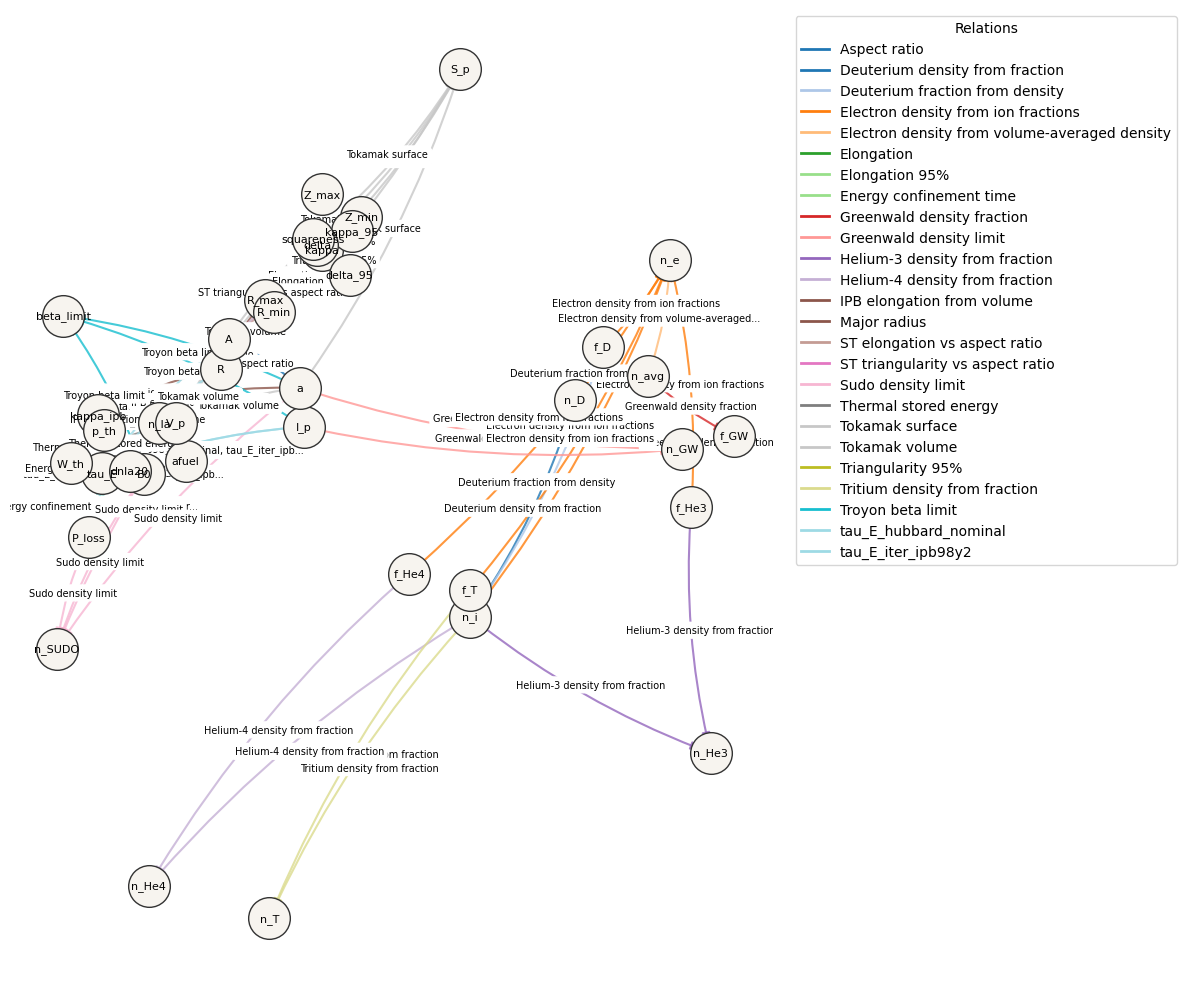

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict

try:
    import networkx as nx
except Exception as exc:
    print("networkx is not available:", exc)
    print("Install with `pip install networkx` if you want the plot.")
    nx = None


def _relation_edges(records):
    edges = []
    for rec in records:
        output = rec["output"]
        if not output:
            continue
        rel = rec["relation"]
        for inp in rec["inputs"]:
            edges.append((inp, output, rel))
    return edges


def _filter_edges_by_relation_limit(edges, max_relations):
    if max_relations is None:
        return edges
    allowed = []
    filtered = []
    for inp, out, rel in edges:
        if rel not in allowed:
            if len(allowed) >= max_relations:
                continue
            allowed.append(rel)
        filtered.append((inp, out, rel))
    return filtered


def _relation_color_map(relations):
    cmap = plt.get_cmap("tab20", max(len(relations), 1))
    return {rel: cmap(i) for i, rel in enumerate(relations)}


def _edge_label_map(edges, max_label_len=None):
    label_map = defaultdict(list)
    for inp, out, rel in edges:
        label_map[(inp, out)].append(rel)
    edge_labels = {}
    for (inp, out), rels in label_map.items():
        uniq = sorted(set(rels))
        label = ", ".join(uniq)
        if max_label_len is not None and len(label) > max_label_len:
            if max_label_len > 3:
                label = label[: max_label_len - 3] + "..."
            else:
                label = label[: max_label_len]
        edge_labels[(inp, out)] = label
    return edge_labels


def plot_relation_graph(
    records,
    max_relations=None,
    layout="spring",
    seed=7,
    draw_edge_labels=True,
    max_label_len=40,
):
    if nx is None:
        return None
    edges = _relation_edges(records)
    edges = _filter_edges_by_relation_limit(edges, max_relations)
    if not edges:
        print("No relations to plot.")
        return None

    relations = sorted({rel for _, _, rel in edges})
    rel_colors = _relation_color_map(relations)

    graph = nx.MultiDiGraph()
    for inp, out, rel in edges:
        graph.add_edge(inp, out, relation=rel, color=rel_colors[rel])

    if layout == "circular":
        pos = nx.circular_layout(graph)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(graph)
    else:
        pos = nx.spring_layout(graph, seed=seed)

    fig, ax = plt.subplots(figsize=(12, 10))
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_color="#f7f4ef",
        edgecolors="#333",
        node_size=900,
        ax=ax,
    )
    nx.draw_networkx_labels(graph, pos, font_size=8, ax=ax)

    for rel in relations:
        rel_edges = [(u, v) for u, v, k, d in graph.edges(keys=True, data=True) if d.get("relation") == rel]
        nx.draw_networkx_edges(
            graph,
            pos,
            edgelist=rel_edges,
            edge_color=[rel_colors[rel]] * len(rel_edges),
            arrows=True,
            arrowsize=12,
            width=1.5,
            alpha=0.8,
            connectionstyle="arc3,rad=0.08",
            ax=ax,
        )

    if draw_edge_labels:
        edge_labels = _edge_label_map(edges, max_label_len=max_label_len)
        label_graph = nx.DiGraph()
        label_graph.add_edges_from(edge_labels.keys())
        nx.draw_networkx_edge_labels(
            label_graph,
            pos,
            edge_labels=edge_labels,
            font_size=7,
            rotate=False,
            ax=ax,
        )

    handles = [plt.Line2D([0], [0], color=rel_colors[rel], lw=2, label=rel) for rel in relations]
    ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", title="Relations")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax


# Example: limit to the first 25 relations to keep the plot readable
plot_relation_graph(records, max_relations=25, layout="spring", draw_edge_labels=True)


## Interactive Graph

This uses PyVis (if installed) to create a zoomable HTML graph.


In [8]:
import json
from collections import defaultdict
from pathlib import Path

try:
    from pyvis.network import Network
except Exception as exc:
    print("pyvis is not available:", exc)
    print("Install with `pip install pyvis` if you want the interactive plot.")
    Network = None


def _shorten_label(text, max_len):
    """Shorten a label for display."""
    if max_len is None:
        return str(text)
    text = str(text)
    if len(text) <= max_len:
        return text
    if max_len <= 3:
        return text[:max_len]
    return text[: max_len - 3] + "..."


def _load_variable_info(path: Path | None = None):
    """Load variable metadata from allowed_variables.yaml.

    Returns:
      - info: mapping variable -> multi-line text
      - alias_map: mapping alias -> [canonical variables]
    """
    try:
        import yaml
    except Exception as exc:
        print("PyYAML is not available:", exc)
        print("Install with `pip install pyyaml` if you want variable details.")
        return {}, {}

    path = path or Path("src/fusdb/registry/allowed_variables.yaml")
    if not path.exists():
        print(f"Variable registry not found at: {path}")
        return {}, {}

    data = yaml.safe_load(path.read_text()) or {}
    info = {}
    alias_map = defaultdict(list)

    for name, meta in data.items():
        if not isinstance(meta, dict):
            continue
        lines = [f"{name}"]

        default_unit = meta.get("default_unit")
        if default_unit:
            lines.append(f"unit: {default_unit}")

        aliases = meta.get("aliases")
        alias_list = []
        if aliases:
            if isinstance(aliases, (list, tuple)):
                alias_list = [str(a) for a in aliases]
                alias_text = ", ".join(alias_list)
            else:
                alias_list = [str(aliases)]
                alias_text = alias_list[0]
            lines.append(f"aliases: {alias_text}")
            for alias in alias_list:
                if alias:
                    alias_map[alias].append(name)

        constraints = meta.get("constraints")
        if constraints:
            if isinstance(constraints, (list, tuple)):
                constraint_text = "; ".join(str(c) for c in constraints)
            else:
                constraint_text = str(constraints)
            lines.append(f"constraints: {constraint_text}")

        desc = meta.get("description")
        if desc:
            if isinstance(desc, (list, tuple)):
                desc_text = " ".join(str(d).strip() for d in desc)
            else:
                desc_text = str(desc)
            lines.append(f"description: {desc_text}")

        info[name] = "\n".join(lines)

    return info, dict(alias_map)


def _load_relation_info():
    """Attempt to load relation source locations.

    This intentionally degrades gracefully: if imports fail (missing deps),
    the HTML still renders and the Info panel still works for variables.
    """
    import inspect
    import importlib
    import pkgutil

    try:
        import fusdb.relations as relations_pkg
    except Exception as exc:
        print("Could not import fusdb.relations:", exc)
        return {}

    info = {}
    for modinfo in pkgutil.walk_packages(relations_pkg.__path__, relations_pkg.__name__ + "."):
        try:
            module = importlib.import_module(modinfo.name)
        except Exception:
            continue

        for obj in module.__dict__.values():
            rel = getattr(obj, "relation", None)
            if rel is None or not hasattr(rel, "name"):
                continue

            try:
                source = inspect.getsource(obj)
            except Exception:
                source = f"{module.__name__}.{getattr(obj, '__name__', '<unknown>')} (source unavailable)"

            entry = {
                "function": getattr(obj, "__name__", "<unknown>"),
                "module": module.__name__,
                "source": source,
            }
            info.setdefault(rel.name, []).append(entry)

    return info


def _build_connection_maps(records):
    var_inputs = defaultdict(set)
    var_outputs = defaultdict(set)
    rel_inputs = defaultdict(set)
    rel_outputs = defaultdict(set)

    for rec in records:
        rel = rec["relation"]
        output = rec["output"]
        inputs = rec["inputs"]
        if output:
            var_outputs[output].add(rel)
            rel_outputs[rel].add(output)
        for inp in inputs:
            var_inputs[inp].add(rel)
            rel_inputs[rel].add(inp)

    var_map = {
        name: {
            "produced_by": sorted(var_outputs.get(name, [])),
            "used_by": sorted(var_inputs.get(name, [])),
        }
        for name in sorted(set(var_inputs) | set(var_outputs))
    }

    rel_map = {
        name: {
            "inputs": sorted(rel_inputs.get(name, [])),
            "outputs": sorted(rel_outputs.get(name, [])),
        }
        for name in sorted(set(rel_inputs) | set(rel_outputs))
    }

    return var_map, rel_map


def _relation_tag_map(records):
    tag_map = defaultdict(set)
    for rec in records:
        rel = rec.get("relation")
        for tag in rec.get("tags") or []:
            if tag:
                tag_map[rel].add(str(tag))
    return {name: sorted(tags) for name, tags in tag_map.items()}


def _json_for_html(obj):
    """Serialize to JSON safe to embed in a <script> tag."""
    text = json.dumps(obj, ensure_ascii=True)
    # Prevent accidental closing of the script tag
    return text.replace("</", "<\\/")


def _expose_pyvis_graph_objects(html: str) -> str:
    """Make nodes/edges/network reachable reliably from injected JS.

    Different pyvis versions scope variables differently.
    This replaces the plain `drawGraph();` call with a wrapper that:
      - captures the returned network
      - stores network/nodes/edges on window.__relationGraph__
      - also mirrors the network to window.network for convenience
    """
    marker = "drawGraph();"
    if marker not in html:
        return html

    replacement = (
        "(function(){\n"
        "  try {\n"
        "    var __net = drawGraph();\n"
        "    window.__relationGraph__ = {\n"
        "      network: __net,\n"
        "      nodes: (typeof nodes !== 'undefined' ? nodes : null),\n"
        "      edges: (typeof edges !== 'undefined' ? edges : null)\n"
        "    };\n"
        "    window.network = __net;\n"
        "  } catch (e) {\n"
        "    console.error('relation_graph: drawGraph() failed', e);\n"
        "  }\n"
        "})();"
    )
    return html.replace(marker, replacement)


def plot_relation_graph_interactive(
    records,
    max_relations=None,
    output_file="relation_graph.html",
    label_max_len=40,
):
    if Network is None:
        return None

    edges = _relation_edges(records)
    edges = _filter_edges_by_relation_limit(edges, max_relations)
    if not edges:
        print("No relations to plot.")
        return None

    relations = sorted({rel for _, _, rel in edges})
    rel_colors = _relation_color_map(relations)

    try:
        from matplotlib.colors import to_hex
    except Exception:
        def to_hex(_color):
            return "#888888"

    nodes = sorted({inp for inp, _, _ in edges} | {out for _, out, _ in edges})

    variable_info, variable_aliases = _load_variable_info()
    relation_info = _load_relation_info()
    var_connections, rel_connections = _build_connection_maps(records)
    relation_tags = _relation_tag_map(records)

    net = Network(height="800px", width="100%", directed=True, notebook=True)
    net.barnes_hut()

    options = {
        "nodes": {
            "shape": "dot",
            "size": 18,
            "font": {"size": 20, "face": "monospace"},
        },
        "edges": {
            "arrows": {"to": {"enabled": True}},
            "font": {"size": 16, "align": "middle"},
        },
        "interaction": {"hover": True},
        "physics": {"barnesHut": {"springLength": 140, "springConstant": 0.03}},
    }
    net.set_options(json.dumps(options))

    for node in nodes:
        label = _shorten_label(node, label_max_len)
        net.add_node(node, label=label, title=str(node))

    for inp, out, rel in edges:
        label = _shorten_label(rel, label_max_len)
        net.add_edge(
            inp,
            out,
            label=label,
            title=str(rel),
            color=to_hex(rel_colors[rel]),
            relation=str(rel),
        )

    html = net.generate_html(notebook=False)
    html = _expose_pyvis_graph_objects(html)

    inject = r"""
<style>
  #relation-toolbox {
    position: fixed;
    top: 12px;
    right: 12px;
    z-index: 9999;
    background: #fff;
    border: 1px solid #ccc;
    padding: 10px;
    max-width: 420px;
    box-shadow: 0 2px 6px rgba(0, 0, 0, 0.15);
    font-family: monospace;
  }
  #relation-toolbox label,
  #relation-toolbox input,
  #relation-toolbox button,
  #relation-toolbox pre {
    font-size: 14px;
  }
  #relation-toolbox input {
    width: 260px;
    padding: 6px;
  }
  #relation-toolbox button {
    margin-left: 6px;
    padding: 6px 10px;
  }
  #search-suggestions {
    margin-top: 6px;
    border: 1px solid #ddd;
    background: #fafafa;
    max-height: 140px;
    overflow: auto;
    display: none;
  }
  #search-suggestions .suggestion {
    padding: 4px 6px;
    cursor: pointer;
  }
  #search-suggestions .suggestion:hover {
    background: #eef;
  }
  #relation-toolbox pre {
    margin: 8px 0 0 0;
    padding: 8px;
    border: 1px solid #ddd;
    max-height: 320px;
    overflow: auto;
    white-space: pre-wrap;
  }
</style>
<div id="relation-toolbox">
  <label for="search-input"><strong>Search</strong></label><br />
  <input id="search-input" type="text" placeholder="Variable, relation, alias, or #tag" />
  <button id="search-button">Go</button>
  <div id="search-suggestions"></div>
  <div style="margin-top:8px;"><strong>Info</strong></div>
  <pre id="info-panel">Click a node or edge to view details.</pre>
</div>
<script type="text/javascript">
window.variableInfo = __VARINFO__;
window.variableAliases = __VARALIASES__;
window.relationInfo = __RELINFO__;
window.varConnections = __VARCONN__;
window.relConnections = __RELCONN__;
window.relationTags = __RELTAGS__;

function setInfo(text) {
  var panel = document.getElementById('info-panel');
  if (!panel) return;
  panel.textContent = text;
}

function getGraphObjects() {
  var networkObj = null;
  var nodesObj = null;
  var edgesObj = null;

  if (window.__relationGraph__ && window.__relationGraph__.network) {
    networkObj = window.__relationGraph__.network;
    nodesObj = window.__relationGraph__.nodes;
    edgesObj = window.__relationGraph__.edges;
  }

  if (!networkObj && window.network) networkObj = window.network;
  if (!networkObj && (typeof network !== 'undefined')) networkObj = network;

  if (!nodesObj && window.nodes) nodesObj = window.nodes;
  if (!nodesObj && (typeof nodes !== 'undefined')) nodesObj = nodes;

  if (!edgesObj && window.edges) edgesObj = window.edges;
  if (!edgesObj && (typeof edges !== 'undefined')) edgesObj = edges;

  // Fallback: derive datasets from the network instance
  try {
    if (networkObj && networkObj.body && networkObj.body.data) {
      nodesObj = nodesObj || networkObj.body.data.nodes;
      edgesObj = edgesObj || networkObj.body.data.edges;
    }
  } catch (e) {}

  return { network: networkObj, nodes: nodesObj, edges: edgesObj };
}

function formatRelationInfo(name) {
  var lines = ['Relation: ' + name];
  var conn = (window.relConnections || {})[name];
  if (conn) {
    if (conn.inputs && conn.inputs.length) {
      lines.push('Inputs: ' + conn.inputs.join(', '));
    }
    if (conn.outputs && conn.outputs.length) {
      lines.push('Outputs: ' + conn.outputs.join(', '));
    }
  }
  var tags = (window.relationTags || {})[name];
  if (tags && tags.length) {
    lines.push('Tags: ' + tags.join(', '));
  }

  var infoItems = (window.relationInfo || {})[name];
  if (infoItems && infoItems.length) {
    lines.push('');
    for (var i = 0; i < infoItems.length; i++) {
      var it = infoItems[i];
      lines.push('---');
      lines.push((it.module || '') + ' :: ' + (it.function || '')); 
      if (it.source) {
        lines.push(it.source);
      }
    }
  } else {
    lines.push('');
    lines.push('(No source details found.)');
  }
  return lines.join('\n');
}

function formatVariableInfo(name) {
  var lines = ['Variable: ' + name];
  var meta = (window.variableInfo || {})[name];
  if (meta) {
    lines.push('');
    lines.push(meta);
  } else {
    // Maybe this was an alias
    var hits = (window.variableAliases || {})[name];
    if (hits && hits.length) {
      lines.push('');
      lines.push('Alias for: ' + hits.join(', '));
    }
  }

  var conn = (window.varConnections || {})[name];
  if (conn) {
    lines.push('');
    lines.push('produced_by: ' + (conn.produced_by.length ? conn.produced_by.join(', ') : '(none)'));
    lines.push('used_by: ' + (conn.used_by.length ? conn.used_by.join(', ') : '(none)'));
  }

  return lines.join('\n');
}

function initInteraction() {
  var g = getGraphObjects();
  var network = g.network;
  var nodes = g.nodes;
  var edges = g.edges;

  if (!network || !nodes || !edges) {
    // Keep retrying; this happens on some pyvis templates.
    setTimeout(initInteraction, 250);
    return;
  }

  // Store for debugging / reuse.
  window.__relationGraph__ = { network: network, nodes: nodes, edges: edges };

  function unselectAll() {
    if (network.unselectAll) {
      network.unselectAll();
      return;
    }
    if (network.setSelection) {
      network.setSelection({ nodes: [], edges: [] });
    }
  }

  function selectNodes(ids) {
    if (network.selectNodes) {
      network.selectNodes(ids);
      return;
    }
    if (network.setSelection) {
      network.setSelection({ nodes: ids, edges: [] });
    }
  }

  function selectEdges(ids) {
    if (network.selectEdges) {
      network.selectEdges(ids);
      return;
    }
    if (network.setSelection) {
      network.setSelection({ nodes: [], edges: ids });
    }
  }

  function handleClick(params) {
    try {
      if (params.nodes && params.nodes.length) {
        var nodeId = params.nodes[0];
        setInfo(formatVariableInfo(nodeId));
        return;
      }
      if (params.edges && params.edges.length) {
        var edgeId = params.edges[0];
        var edge = edges.get(edgeId);
        var relName = (edge && (edge.relation || edge.label)) || 'relation';
        setInfo(formatRelationInfo(relName));
      }
    } catch (e) {
      console.error('relation_graph: click handler failed', e);
    }
  }

  network.on('click', handleClick);
  network.on('selectNode', handleClick);
  network.on('selectEdge', handleClick);

  var suggestionBox = document.getElementById('search-suggestions');
  var toolbox = document.getElementById('relation-toolbox');

  function buildSearchIndex() {
    var items = [];
    var seen = {};
    function add(label, value, type) {
      var key = type + '|' + label;
      if (seen[key]) return;
      seen[key] = true;
      items.push({ label: String(label), value: String(value), type: type });
    }

    var nodeIds = nodes.getIds();
    for (var i = 0; i < nodeIds.length; i++) {
      var id = nodeIds[i];
      add(id, id, 'variable');
    }

    var relNames = Object.keys(window.relationInfo || {});
    for (var j = 0; j < relNames.length; j++) {
      add(relNames[j], relNames[j], 'relation');
    }

    var aliasNames = Object.keys(window.variableAliases || {});
    for (var k = 0; k < aliasNames.length; k++) {
      add(aliasNames[k], aliasNames[k], 'alias');
    }

    var relTags = window.relationTags || {};
    var relTagKeys = Object.keys(relTags);
    for (var t = 0; t < relTagKeys.length; t++) {
      var rel = relTagKeys[t];
      var tags = relTags[rel] || [];
      for (var tt = 0; tt < tags.length; tt++) {
        add('#' + tags[tt], '#' + tags[tt], 'tag');
      }
    }

    return items;
  }

  function hideSuggestions() {
    if (!suggestionBox) return;
    suggestionBox.style.display = 'none';
    suggestionBox.innerHTML = '';
  }

  function showSuggestions(items) {
    if (!suggestionBox) return;
    suggestionBox.innerHTML = '';
    for (var i = 0; i < items.length; i++) {
      var item = items[i];
      var row = document.createElement('div');
      row.className = 'suggestion';
      row.textContent = item.label + ' [' + item.type + ']';
      row.dataset.value = item.value;
      row.addEventListener('click', function(evt) {
        var value = evt.currentTarget.dataset.value;
        var input = document.getElementById('search-input');
        if (input) input.value = value;
        hideSuggestions();
        doSearch();
      });
      suggestionBox.appendChild(row);
    }
    suggestionBox.style.display = 'block';
  }

  function updateSuggestions() {
    var input = document.getElementById('search-input');
    if (!input) return;
    if (!window.searchIndex) {
      window.searchIndex = buildSearchIndex();
    }
    var term = input.value.trim();
    if (!term) {
      hideSuggestions();
      return;
    }
    var termNorm = term.toLowerCase();
    var maxItems = 10;
    var matches = [];
    var seen = {};

    for (var i = 0; i < window.searchIndex.length; i++) {
      var item = window.searchIndex[i];
      var label = item.label.toLowerCase();
      if (label.indexOf(termNorm) === 0 || label.indexOf(termNorm) !== -1) {
        if (!seen[item.label]) {
          seen[item.label] = true;
          matches.push(item);
          if (matches.length >= maxItems) break;
        }
      }
    }

    if (!matches.length) {
      hideSuggestions();
      return;
    }
    showSuggestions(matches);
  }

  function doSearch() {
    var input = document.getElementById('search-input');
    if (!input) return;
    var term = input.value.trim();
    hideSuggestions();

    if (!term) {
      unselectAll();
      setInfo('Click a node or edge to view details.');
      return;
    }

    function normalize(value, caseSensitive) {
      return caseSensitive ? String(value) : String(value).toLowerCase();
    }

    function collectTagMatches(matchFn) {
      var matches = {};
      var relTags = window.relationTags || {};
      var relNames = Object.keys(relTags);
      for (var i = 0; i < relNames.length; i++) {
        var relName = relNames[i];
        var tags = relTags[relName] || [];
        for (var j = 0; j < tags.length; j++) {
          var tag = tags[j];
          if (matchFn(tag)) {
            if (!matches[tag]) matches[tag] = [];
            if (matches[tag].indexOf(relName) === -1) matches[tag].push(relName);
          }
        }
      }
      return matches;
    }

    function attemptTagSearch(tagTerm, caseSensitive) {
      var termNorm = normalize(tagTerm, caseSensitive);
      function exact(value) { return normalize(value, caseSensitive) === termNorm; }
      function contains(value) { return normalize(value, caseSensitive).indexOf(termNorm) !== -1; }

      var matches = collectTagMatches(exact);
      if (!Object.keys(matches).length) matches = collectTagMatches(contains);

      var tags = Object.keys(matches);
      if (!tags.length) return false;

      // Build relation set: any relation that has at least one matched tag
      var relSet = {};
      for (var t = 0; t < tags.length; t++) {
        var rels = matches[tags[t]] || [];
        for (var r = 0; r < rels.length; r++) relSet[rels[r]] = true;
      }

      var relNames = Object.keys(relSet).sort();

      // Build info text: list relations (and I/O if available)
      var lines = [];
      lines.push('Tag search: #' + tags.map(function(x){return x;}).join(', #'));
      lines.push('Relations (' + relNames.length + '):');

      var relConn = window.relationConnections || {};
      var relTags = window.relationTags || {};

      for (var i = 0; i < relNames.length; i++) {
        var rel = relNames[i];
        var conn = relConn[rel] || {};
        var ins = (conn.inputs || []);
        var outs = (conn.outputs || []);
        var tgs = (relTags[rel] || []).map(function(x){ return '#' + x; });

        lines.push('');
        lines.push('- ' + rel + (tgs.length ? '  [' + tgs.join(' ') + ']' : ''));
        if (ins.length)  lines.push('  inputs:  ' + ins.join(', '));
        if (outs.length) lines.push('  outputs: ' + outs.join(', '));
      }

      setInfo(lines.join('\n'));

      // Select all edges whose relation is in relSet (keep your existing behavior)
      var edgeIds = [];
      var edgeList = edges.getIds();
      for (var e = 0; e < edgeList.length; e++) {
        var edge = edges.get(edgeList[e]);
        if (edge && relSet[edge.relation]) edgeIds.push(edgeList[e]);
      }
      if (edgeIds.length) {
        unselectAll();
        selectEdges(edgeIds);
      }

      return true;
    }


    var isTagSearch = term.charAt(0) === '#';
    if (isTagSearch) {
      var tagTerm = term.slice(1);
      if (!tagTerm) {
        setInfo('Type a tag after #');
        return;
      }
      if (attemptTagSearch(tagTerm, true)) return;
      if (attemptTagSearch(tagTerm, false)) return;
      setInfo('No tag match for: ' + term);
      return;
    }

    function findNode(matchFn) {
      var ids = nodes.getIds();
      for (var i = 0; i < ids.length; i++) {
        var id = ids[i];
        var node = nodes.get(id);
        var label = (node && node.label) || id;
        if (matchFn(id) || matchFn(label)) return id;
      }
      return null;
    }

    function findEdge(matchFn) {
      var ids = edges.getIds();
      for (var i = 0; i < ids.length; i++) {
        var id = ids[i];
        var edge = edges.get(id);
        var label = (edge && (edge.label || edge.relation)) || '';
        if (matchFn(label)) return id;
      }
      return null;
    }

    function findRelationName(matchFn) {
      var names = Object.keys(window.relationInfo || {});
      for (var i = 0; i < names.length; i++) {
        if (matchFn(names[i])) return names[i];
      }
      return null;
    }

    function findVariableName(matchFn) {
      var names = Object.keys(window.variableInfo || {});
      for (var i = 0; i < names.length; i++) {
        if (matchFn(names[i])) return names[i];
      }
      return null;
    }

    function findAlias(matchFn) {
      var aliases = Object.keys(window.variableAliases || {});
      for (var i = 0; i < aliases.length; i++) {
        if (matchFn(aliases[i])) return aliases[i];
      }
      return null;
    }

    function resolveAlias(alias) {
      var hits = (window.variableAliases || {})[alias] || [];
      return hits.length ? hits[0] : null;
    }

    function selectNode(nodeId) {
      selectNodes([nodeId]);
      try { if (network.focus) network.focus(nodeId, { scale: 1.3 }); } catch (e) {}
      setInfo(formatVariableInfo(nodeId));
    }

    function selectEdge(edgeId) {
      selectEdges([edgeId]);
      var edge = edges.get(edgeId);
      var relName = (edge && (edge.relation || edge.label)) || 'relation';
      setInfo(formatRelationInfo(relName));
    }

    function attemptSearch(caseSensitive) {
      var termNorm = normalize(term, caseSensitive);

      function exact(value) { return normalize(value, caseSensitive) === termNorm; }
      function startsWith(value) { return normalize(value, caseSensitive).indexOf(termNorm) === 0; }
      function contains(value) { return normalize(value, caseSensitive).indexOf(termNorm) !== -1; }

      var nodeId = findNode(exact);
      if (nodeId) { selectNode(nodeId); return true; }

      var relName = findRelationName(exact);
      if (relName) { setInfo(formatRelationInfo(relName)); return true; }

      var alias = findAlias(exact);
      if (alias) {
        var target = resolveAlias(alias);
        if (target) selectNode(target); else setInfo(formatVariableInfo(alias));
        return true;
      }

      nodeId = findNode(startsWith);
      if (nodeId) { selectNode(nodeId); return true; }

      nodeId = findNode(contains);
      if (nodeId) { selectNode(nodeId); return true; }

      var edgeId = findEdge(contains);
      if (edgeId) { selectEdge(edgeId); return true; }

      relName = findRelationName(contains);
      if (relName) { setInfo(formatRelationInfo(relName)); return true; }

      var varName = findVariableName(contains);
      if (varName) { setInfo(formatVariableInfo(varName)); return true; }

      alias = findAlias(contains);
      if (alias) {
        var target2 = resolveAlias(alias);
        if (target2) selectNode(target2); else setInfo(formatVariableInfo(alias));
        return true;
      }

      return false;
    }

    if (attemptSearch(true)) return;
    if (attemptSearch(false)) return;
    setInfo('No match for: ' + term);
  }

  var btn = document.getElementById('search-button');
  if (btn) btn.addEventListener('click', doSearch);

  var input = document.getElementById('search-input');
  if (input) {
    input.addEventListener('keydown', function(evt) {
      if (evt.key === 'Enter') doSearch();
    });
    input.addEventListener('input', updateSuggestions);
    input.addEventListener('focus', updateSuggestions);
  }

  if (toolbox) {
    document.addEventListener('click', function(evt) {
      if (!toolbox.contains(evt.target)) hideSuggestions();
    });
  }
}

if (document.readyState === 'loading') {
  document.addEventListener('DOMContentLoaded', initInteraction);
} else {
  initInteraction();
}
</script>
"""

    inject = inject.replace('__VARINFO__', _json_for_html(variable_info))
    inject = inject.replace('__VARALIASES__', _json_for_html(variable_aliases))
    inject = inject.replace('__RELINFO__', _json_for_html(relation_info))
    inject = inject.replace('__VARCONN__', _json_for_html(var_connections))
    inject = inject.replace('__RELCONN__', _json_for_html(rel_connections))
    inject = inject.replace('__RELTAGS__', _json_for_html(relation_tags))

    html = html.replace('</body>', inject + '\n</body>')
    Path(output_file).write_text(html, encoding='utf-8')
    print(f"Saved interactive graph to {output_file}")
    return output_file


# Example: generate a zoomable graph (writes relation_graph.html)
plot_relation_graph_interactive(records, max_relations=25, output_file="relation_graph.html", label_max_len=40)


Variable registry not found at: src/fusdb/registry/allowed_variables.yaml
Saved interactive graph to relation_graph.html


'relation_graph.html'